# Generating SLiM exome recombination maps

This notebook generates three sets of recombination map files for SLiM.

1. Recombination rates between individual sites from the archaic admixture array.

2. Recombination rates between exonic regions.

3. Recombination rates between exonic regions and sites from the archaic admixture array.

In [1]:
from pybedtools import BedTool
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [3]:
RECOMB_RATE = 1e-8 # crossovers per bp per generation

## Exon coordinates processing

First download the GTF annotations:

In [4]:
gtf = pd.read_table('ftp://ftp.ensembl.org/pub/release-75/gtf/homo_sapiens/Homo_sapiens.GRCh37.75.gtf.gz',
                    header=None, sep='\t', skipinitialspace=True, skiprows=5, compression='gzip',
                    names=['chrom', 'source', 'feature', 'start', 'end',
                           'score', 'strand', 'frame', 'attribute'], low_memory=False)

How does the data look like?

In [5]:
gtf.head()

,chrom,source,feature,start,end,score,strand,frame,attribute
0,1,pseudogene,gene,11869,14412,.,+,.,"gene_id ""ENSG00000223972""; gene_name ""DDX11L1""..."
1,1,processed_transcript,transcript,11869,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
2,1,processed_transcript,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
3,1,processed_transcript,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."
4,1,processed_transcript,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972""; transcript_id ""ENST..."


In [6]:
gtf.source.value_counts()

protein_coding                        2001054
nonsense_mediated_decay                293471
processed_transcript                   173401
retained_intron                        150034
lincRNA                                 55928
antisense                               45811
processed_pseudogene                    24517
pseudogene                              17830
unprocessed_pseudogene                  13763
miRNA                                   10209
transcribed_unprocessed_pseudogene       7931
misc_RNA                                 6554
snRNA                                    6215
snoRNA                                   4791
sense_intronic                           3241
polymorphic_pseudogene                   1906
rRNA                                     1706
unitary_pseudogene                       1467
sense_overlapping                        1463
IG_V_gene                                1277
transcribed_processed_pseudogene         1182
non_stop_decay                    

In [7]:
gtf.feature.value_counts()

exon              1306656
CDS                791856
UTR                304070
transcript         215170
stop_codon          73411
start_codon         73358
gene                63677
Selenocysteine        114
Name: feature, dtype: int64

Take only autosomal protein-coding regions, since we won't be simulating sex chromosomes:

In [8]:
AUTOSOMES = [str(i + 1) for i in range(22)]

In [9]:
exons = gtf[gtf.chrom.isin(AUTOSOMES) &
           (gtf.source == "protein_coding") &
           (gtf.feature == "exon")]

Merge the overlapping exons:

In [10]:
exons = BedTool.from_dataframe(exons).sort().merge().to_dataframe()

In [11]:
exons['type'] = 'exon'

Convert chromosome IDs to integers and sort exons by chromosome:

In [12]:
exons.chrom = exons.chrom.astype(int)
exons.sort_values(by=['chrom', 'start'], inplace=True)

What is the distribution of exon lengths?

In [13]:
((exons.end - exons.start)).describe()

count    214193.000000
mean        337.708039
std         776.506070
min           1.000000
25%          96.000000
50%         138.000000
75%         217.000000
max       24409.000000
dtype: float64

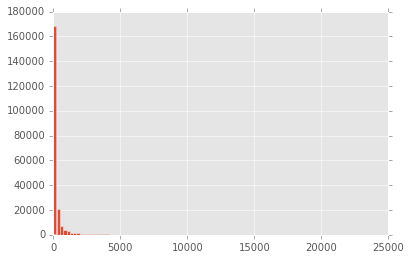

In [14]:
plt.figure_ = plt.hist((exons.end - exons.start), bins=100)

Filter out some very small exons:

In [15]:
exons = exons[(exons.end - exons.start) > 5]

Specify the recombination rate within exons:

In [16]:
exons.ix[exons.type == 'exon', 'recomb_rate'] = RECOMB_RATE

In [39]:
exons.head()

,chrom,start,end,type,recomb_rate
0,1,69090,70008,exon,1.000000e-08
1,1,134900,135802,exon,1.000000e-08
2,1,137620,139379,exon,1.000000e-08
3,1,367639,368634,exon,1.000000e-08
4,1,621058,622053,exon,1.000000e-08


## Process positions from the archaic admixture array

Load the coordinates of sites from the archaic admixture array:

In [17]:
array_sites = pd.read_table('../raw_data/ice_age/filter.gz', names=['chrom', 'end', 'set_1', 'set_2'])

Subset to sites in the so called "Set 1" (see `raw_data/ice_age/README.md` for more information):

In [18]:
array_sites = array_sites[array_sites.set_1 == 1]

Find sites that don't fall within exonic regions. These will be simulated individually when building the recombination map. The ones within the exons will be recombining simply as part of the exons:

In [19]:
array_sites['start'] = array_sites.end - 1

In [20]:
array_sites = array_sites[['chrom', 'start', 'end']]

In [21]:
array_sites['type'] = 'snp'

## Create a union of exon regions with admixture array informative positions

Informative sites within exons will be simulated simply as part of the exons. Inter-exon informative sites will be simulated individually, with an appropriate recombination rate set between them and both adjacent exons or other informative sites.

In [22]:
exome = BedTool.from_dataframe(exons)

# take subset of array sites that lie outside exons
array = BedTool.from_dataframe(array_sites).intersect(exome, v=True)

In [23]:
exons_and_sites = pd.concat([exome.to_dataframe(),
                             array.to_dataframe()]).sort_values(by=['chrom', 'start']).reset_index(drop=True)

In [24]:
# rename and rearrange columns
exons_and_sites = exons_and_sites.rename(columns={'name': 'type', 'score': 'recomb_rate'})[['chrom', 'start', 'end', 'type', 'recomb_rate']]

## Generating the recombination map

Recombination rate between exons and/or informative positions is implemented by inserting a 1 bp "gap" between each adjacent region/site and setting the recombination rate at these positions to $L \times 1\cdot10^{-8}$ crossovers per generation ($L$ is the distance between exons/sites).

The recombination rate of the "gap" between the last feature on one chromosome and the first feature on another chromosome will be 0.5.

In [25]:
def add_recombination_gaps(regions):
    """Add 1 bp "recombination gaps" between each record in
    a given DataFrame.
    """
    # create a new DataFrame with coordinates of 1 bp gaps
    gaps = pd.DataFrame({'chrom'       : regions.chrom.values,
                         'start'       : regions.end.values,
                         'end'         : regions.end.values + 1,
                         'recomb_rate' : list(RECOMB_RATE * (regions.start[1:].values - regions.end[:-1].values)) + [0.5],
                         'type'        : 'gap'},
                        columns=['chrom', 'start', 'end', 'recomb_rate', 'type'])

    # merge the dataframes of regions and gap coordinates
    regions_and_gaps = pd.concat([regions.query('type != "snp"'), gaps]).sort_values(by=['chrom', 'start']).reset_index(drop=True)
    
    # calculate the end position of each simulated region and gap
    # (this is how a recombination map is specified for SLiM)
    regions_and_gaps['interval_end'] = (regions_and_gaps.end - regions_and_gaps.start).cumsum()
    
    # return recombination map between regions and admixture array sites
    # (snp records can be ignored, since they were used only to place
    # 1 bp "gaps" in between)
    return regions_and_gaps[['chrom', 'start', 'end', 'type', 'interval_end', 'recomb_rate']]


def create_genome_recomb_map(regions):
    """Create recombination map for all chromosomes.
    
    SLiM simulates the whole genome as one segment. Therefore, all
    exons on all chromosomes have to be concatenated and all coordinates
    have to be shifted appropriately (i.e. first coordinate on the chromosome 2
    has to be incremented by a last coordinate of the chromosome 1).
    """
    recomb_map = {}
    previous_end = 0

    for chrom in AUTOSOMES:
        # add recombination gaps between regions on this chromosome
        recomb_map[chrom] = add_recombination_gaps(regions.query('chrom == {}'.format(chrom)))

        # increment the positions of the recombination map based on the
        # last position on the previous chromosome
        recomb_map[chrom].interval_end += previous_end

        # get the currently last position of the
        previous_end = max(recomb_map[chrom].interval_end)
        
    # concatenate exome recombination maps of all chromosomes
    recomb_map = pd.concat(recomb_map, ignore_index=True).sort_values(by='interval_end')

    # remove the very last base of the recombination map
    # (it has a 0.5 recombination rate anyway and there's no other chromosome
    # after it)
    recomb_map = recomb_map[:-1]
    
    return recomb_map

### Recombination map of informative positions from the admixture array

In [26]:
sites_recomb_map = create_genome_recomb_map(array_sites)

In [27]:
sites_recomb_map.tail()

,chrom,start,end,type,interval_end,recomb_rate
436719,22,51147735,51147736,gap,783969,0.000051
436720,22,51152866,51152867,gap,783970,0.000020
436721,22,51154908,51154909,gap,783971,0.000187
436722,22,51173632,51173633,gap,783972,0.000005
436723,22,51174091,51174092,gap,783973,0.000032


In [28]:
array_sites.tail()

,chrom,start,end,type
954450,22,51152865,51152866,snp
954451,22,51154907,51154908,snp
954453,22,51173631,51173632,snp
954454,22,51174090,51174091,snp
954455,22,51177247,51177248,snp


#### Recombination map with exons only

This will be used in the mutation accumulation phase.

In [29]:
exons_recomb_map = create_genome_recomb_map(exons)

In [30]:
exons_recomb_map.tail()

,chrom,start,end,type,interval_end,recomb_rate
288404,22,51220615,51220779,exon,72547537,1.000000e-08
288405,22,51220779,51220780,gap,72547538,4.170000e-06
288406,22,51221196,51221714,exon,72548056,1.000000e-08
288407,22,51221714,51221715,gap,72548057,2.140000e-06
288408,22,51221928,51222091,exon,72548220,1.000000e-08


In [31]:
exons.tail()

,chrom,start,end,type,recomb_rate
144296,22,51215097,51215177,exon,1.000000e-08
144297,22,51216379,51216409,exon,1.000000e-08
144298,22,51220615,51220779,exon,1.000000e-08
144299,22,51221196,51221714,exon,1.000000e-08
144300,22,51221928,51222091,exon,1.000000e-08


#### Recombination map of exons and informative positions from the admixture array

This will be used to simulate the fate of introgressed sequence after Neanderthal admixture.

In [32]:
exons_and_sites_recomb_map = create_genome_recomb_map(exons_and_sites)

In [33]:
exons_and_sites_recomb_map.tail()

,chrom,start,end,type,interval_end,recomb_rate
712341,22,51220615,51220779,exon,73312246,1.000000e-08
712342,22,51220779,51220780,gap,73312247,4.170000e-06
712343,22,51221196,51221714,exon,73312765,1.000000e-08
712344,22,51221714,51221715,gap,73312766,2.140000e-06
712345,22,51221928,51222091,exon,73312929,1.000000e-08


In [34]:
exons_and_sites.tail()

,chrom,start,end,type,recomb_rate
978742,22,51215097,51215177,exon,1.000000e-08
978743,22,51216379,51216409,exon,1.000000e-08
978744,22,51220615,51220779,exon,1.000000e-08
978745,22,51221196,51221714,exon,1.000000e-08
978746,22,51221928,51222091,exon,1.000000e-08


## Output the results in a format suitable for import into SLiM

In [35]:
!mkdir -p ../clean_data

In [36]:
sites_recomb_map[['interval_end', 'recomb_rate']].to_csv('../clean_data/recomb_map__array_sites.txt', sep='\t', index=False, header=False)

In [37]:
exons_recomb_map[['interval_end', 'recomb_rate']].to_csv('../clean_data/recomb_map__exome.txt', sep='\t', index=False, header=False)

In [38]:
exons_and_sites_recomb_map[['interval_end', 'recomb_rate']].to_csv('../clean_data/recomb_map__exome_with_array_sites.txt', sep='\t', index=False, header=False)